# Smoothing time series data in Python

The [VaMpy](https://github.com/akdiem/vampy) [1] software library requires flow rate over time as the inlet boundary condition. To obtain this, flow velocity in the middle cerebral artery (MCA) was measured in a healthy adult male subject. The flow curve is averaged over the number of heart beats using a Fourier transform, resulting in a smooth curve used to demonstrate that pulsations generated by the heart beat are not strong enough to drive intra-mural peri-arterial drainage [2]. 

Start by importing a number of useful libraries and adjust plot settings to make them more visually appealing

In [202]:
import numpy as np
import numpy.fft as npfft
import math, cmath
import sys
import matplotlib.pylab as plt
from scipy.optimize import curve_fit

%matplotlib inline

plt.rcParams['axes.labelsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Arial']

WIDTH = 510
FACTOR = 1.0  # the fraction of the width you'd like the figure to occupy
fig_width_pt  = WIDTH * FACTOR
inches_per_pt = 1.0 / 72.27
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
fig_height_in = fig_width_in * golden_ratio   # figure height in inches
fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
fig_dims_half = [fig_width_in, fig_height_in/2]

log = math.log

Write some simple routines to read and write data files

In [203]:
def read_data(fname):
    f = open(fname, 'r')
    lines = f.readlines()
    f.close()
    time = []
    data = []
    for line in lines:
        if '%' not in line:
            d = line.split(',')
            time.append(float(d[0]))
            data.append(float(d[1]))
    return (time, data)

def save_data(fname, data):
    f = open(fname, 'w')
    for i in range(len(data)):
        f.write('%d,%.4f\n' % (i, data[i]))
    f.close()
    return 0

The measured data contains velocity measurements in cm/s for many heart beats. However, some time at the beginning was required to properly set the Doppler sonography probe in place, only the final ten heart beats are considered. 

Load the measured data and plot it

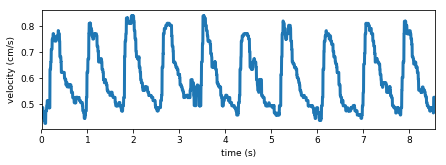

In [227]:
step, MCA_in = read_data("data_smoothing/MCA57.csv")
T = 60/70 # length of a heart beat in seconds
n = 215 # number of data points per heart beat
dt = T/n # time step size
t = [s*dt for s in step] # time array
w = 10 # number of heart beats used
ti = -w*n # first data point to be used

plt.figure(figsize=fig_dims_half)
plt.plot(t[ti:], MCA_in[ti:], lw=3)
plt.xlabel("time (s)")
plt.ylabel("velocity (cm/s)")
plt.xlim([t[ti], max(t)])
plt.show()

For future reference, we store those ten heart beats in a new array

In [228]:
MCA_in = MCA_in[ti:]

Data smoothing is carried out using a Fourier transform. This is useful as we can filter for high frequencies (i.e. noise). We transform our data into the Fourier spectrum using Numpy and delete high frequencies, before transforming back into the time spectrum. Don't forget to discard the imaginary parts.

In [237]:
f = npfft.fft(MCA_in)
f[150:] = 0
inlet = npfft.ifft(f).real
inlet = inlet.reshape((w, n))

Plotting all the smoothed curves shows that most curves have very similar shapes

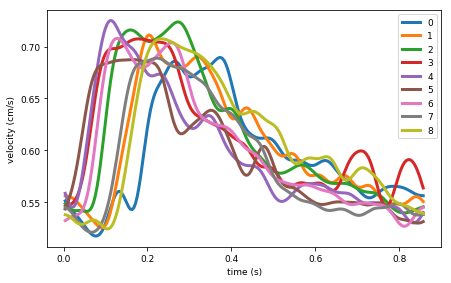

In [257]:
plt.figure(figsize=fig_dims)
for i in range(w-1):
    plt.plot(t[:n], inlet[i,:], lw=3, label="%d" % (i))
plt.xlabel("time (s)")
plt.ylabel("velocity (cm/s)")
plt.legend()
plt.show()

We will use curve 2 as the inlet curve

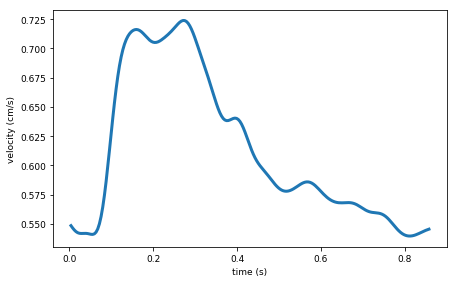

In [258]:
plt.figure(figsize=fig_dims)
plt.plot(t[:n], inlet[2,:], lw=3)
plt.xlabel("time (s)")
plt.ylabel("velocity (cm/s)")
plt.show()

Finally, save the data

In [260]:
save_data("data_smoothing/inlet.csv", inlet[3,:])

0

## References

[1] Diem AK and Bressloff NW (2017) VaMpy: A Python Package to Solve 1D Blood Flow Problems. Journal of Open Research Software 5(1), p.17. doi: http://doi.org/10.5334/jors.159

[2] Diem AK, MacGregor Sharp M, Gatherer M, Bressloff NW, Carare RO and Richardson G (2017) Arterial Pulsations cannot Drive Intramural Periarterial Drainage: Significance for Aβ Drainage. Frontiers in Neuroscience 11:475. doi: https://doi.org/10.3389/fnins.2017.00475